In [1]:
#############
# Reference
# https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9 
#

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "/home/mx19/datasets/hot-dog-not-hot-dog/"
print("The data lies here =>", root_dir)

    
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

print(hotdog_dataset)
print(hotdog_dataset.class_to_idx)


We're using => cuda
The data lies here => /home/mx19/datasets/hot-dog-not-hot-dog/
Dataset ImageFolder
    Number of datapoints: 498
    Root location: /home/mx19/datasets/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
{'hot_dog': 0, 'not_hot_dog': 1}


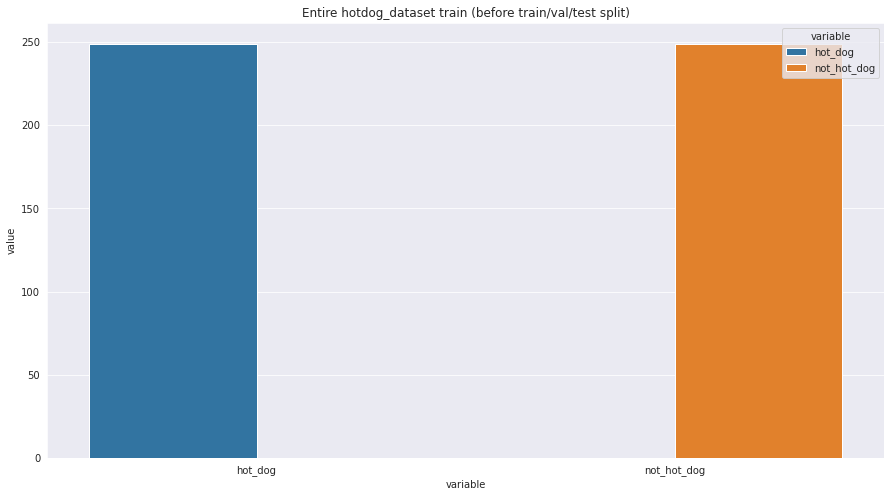

In [3]:
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}
##print(idx2class) #{0: 'hot_dog', 1: 'not_hot_dog'}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


##print(get_class_distribution(hotdog_dataset)) #{'hot_dog': 249, 'not_hot_dog': 249}

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), plot_title="Entire hotdog_dataset train (before train/val/test split)")
plt.show()


In [4]:
##############################
##### Model Parameters

#BATCH_SIZE = 64 #RuntimeError: Unable to find a valid cuDNN algorithm to run convolution
BATCH_SIZE = 48 # 32 
LEARNING_RATE = 0.000005 # 0.009 #0.00001 #0.008; 0.001; 0.000005
EPOCHS = 50



val_split_index 99
train_idx [208, 107, 397, 71, 482, 6, 410, 113, 236, 299, 155, 272, 7, 137, 8, 429, 430, 366, 284, 210, 188, 428, 49, 134, 363, 408, 239, 59, 493, 461, 409, 483, 229, 297, 55, 293, 488, 456, 455, 421, 186, 194, 52, 74, 26, 486, 4, 318, 329, 245, 5, 141, 381, 135, 491, 122, 22, 68, 20, 367, 14, 278, 225, 64, 379, 231, 81, 354, 302, 497, 469, 453, 160, 476, 362, 494, 206, 319, 51, 306, 450, 330, 164, 106, 479, 63, 342, 425, 437, 320, 89, 312, 460, 93, 298, 457, 308, 393, 92, 18, 198, 145, 158, 150, 477, 167, 255, 230, 433, 66, 309, 253, 140, 101, 387, 2, 406, 17, 146, 249, 263, 30, 114, 247, 103, 403, 310, 176, 246, 116, 168, 413, 120, 261, 112, 417, 418, 282, 136, 190, 345, 181, 126, 281, 252, 405, 371, 352, 232, 133, 33, 474, 162, 34, 44, 97, 85, 61, 199, 268, 218, 73, 35, 303, 29, 490, 339, 441, 217, 27, 332, 378, 156, 470, 343, 138, 212, 104, 348, 344, 422, 215, 383, 189, 214, 204, 234, 259, 67, 24, 216, 223, 129, 111, 166, 415, 392, 40, 274, 355, 79, 313, 315, 13,

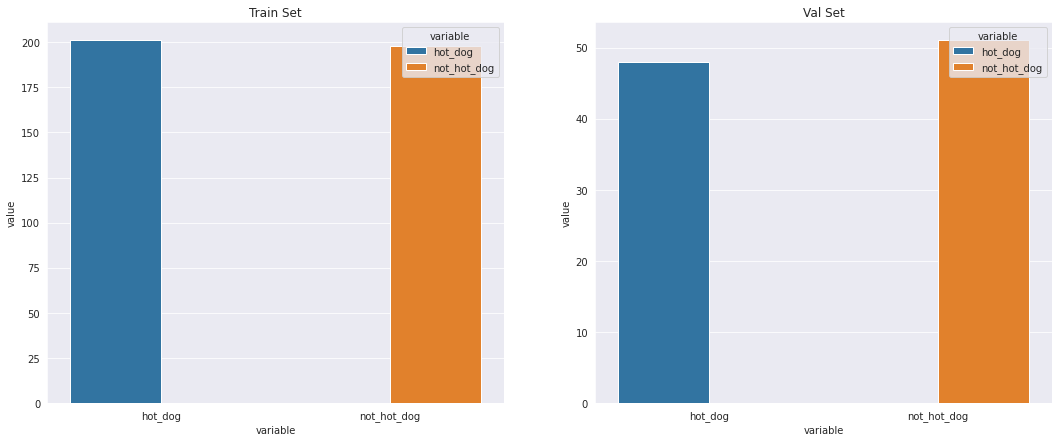

In [5]:
###########################
##### TEST

##Load our test dataset.

hotdog_dataset_size = len(hotdog_dataset)
hotdog_dataset_indices = list(range(hotdog_dataset_size))
#print(hotdog_dataset_size) # 498
#print(hotdog_dataset_indices) # [0, 1, 2, 3 ...... 495, 496, 497]

np.random.shuffle(hotdog_dataset_indices)

################################################################
# We choose the split index to be 20% (0.2) of the dataset size.

# train_split_index = int(np.floor(0.03 * hotdog_dataset_size))
# val_split_index = int(np.floor(0.97 * hotdog_dataset_size))
val_split_index = int(np.floor(0.2 * hotdog_dataset_size))
#print(f'train_split_index {train_split_index}')
print(f'val_split_index {val_split_index}')

train_idx = hotdog_dataset_indices[val_split_index:]
val_idx = hotdog_dataset_indices[:val_split_index]
print(f'train_idx {train_idx}') # [train_split_index ...  hotdog_dataset_size]
print(f'val_idx {val_idx}') # [0... val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)


print(train_loader.dataset)
print(val_loader.dataset)



hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)
print(f'hotdog_dataset_test: {hotdog_dataset_test}')


def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict


print(get_class_distribution_loaders(train_loader, hotdog_dataset))
print(get_class_distribution_loaders(val_loader, hotdog_dataset))
print(get_class_distribution_loaders(test_loader, hotdog_dataset))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])
plt.show()


Train_loader.dataset:
   Dataset ImageFolder
    Number of datapoints: 498
    Root location: /home/mx19/datasets/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
   
torch.Size([48, 3, 224, 224])
torch.Size([48])
OUTPUT LABEL TENSOR:  tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1])

OUPUT LABEL TENSOR SHAPE:  torch.Size([48])
PRINT single_batch[0][0].shape torch.Size([3, 224, 224])


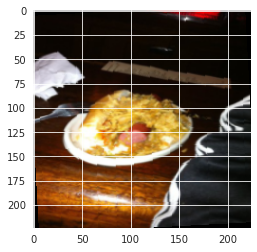

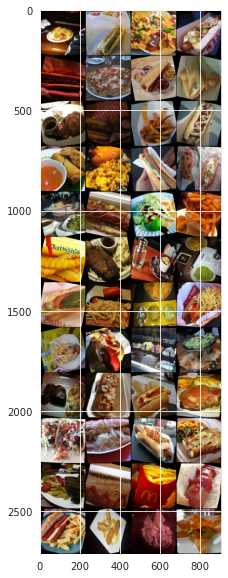

In [6]:

print(f'Train_loader.dataset:')
print(f'   {train_loader.dataset}')
print(f'   ')
single_batch = next(iter(train_loader))
#single_batch = next(iter(val_loader))

# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
print(single_batch[0].shape) # torch.Size([32, 3, 224, 224])
print(single_batch[1].shape) #torch.Size([32])

print("OUTPUT LABEL TENSOR: ", single_batch[1])
print("\nOUPUT LABEL TENSOR SHAPE: ", single_batch[1].shape)


# Selecting the first image tensor from the batch.
single_image = single_batch[0][0]
print(f'PRINT single_batch[0][0].shape {single_image.shape}'  )
plt.imshow(single_image.cpu().detach().numpy().transpose((1, 2, 0)))
plt.show()

single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))
plt.show()


In [7]:

class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x

    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block


In [8]:
model = HotDogClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [9]:
# function to calculate accuracy per epoch.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


#We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [10]:
#########################
## Let’s TRAIN our model!

print("Begin training.")
epoch_number = EPOCHS

for e in tqdm(range(1, epoch_number)):

    ## TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        #print(X_train_batch.size()) ##torch.Size([32, 3, 224, 224])
        y_train_pred = model(X_train_batch).squeeze()
        #print(y_train_pred.size()) ##torch.Size([32, 2])
        #print(y_train_batch.size()) ##torch.Size([32])
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    ## VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            #print(X_val_batch.size()) ##torch.Size([1, 3, 224, 224])
            #print(y_val_batch.size()) ##torch.Size([1]) #LABEL_SIZE
            #print(y_val_batch) #tensor([0], device='cuda:0') or tensor([1], device='cuda:0') # LABEL VALUE
            y_val_pred = model(X_val_batch).squeeze()
            #print(y_val_pred.size()) ##torch.Size([2])
            #print(y_val_pred) #tensor([-0.8276,  1.1471], device='cuda:0')
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            #print(y_val_pred.size()) ##torch.Size([1, 2])
            #print(y_val_pred) #tensor([[ 1.4408, -1.0971]], device='cuda:0')
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))

    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
            
    print(f'Epoch {e+0:02}: | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f} Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')


Begin training.


  2%|███▏                                                                                                                                                      | 1/49 [00:06<05:32,  6.93s/it]

Epoch 01: | Train Acc: 52.556| Val Acc: 48.485 Train Loss: 0.73427 | Val Loss: 0.69323


  4%|██████▎                                                                                                                                                   | 2/49 [00:12<04:41,  5.98s/it]

Epoch 02: | Train Acc: 56.222| Val Acc: 48.485 Train Loss: 0.71153 | Val Loss: 0.71514


  6%|█████████▍                                                                                                                                                | 3/49 [00:17<04:21,  5.68s/it]

Epoch 03: | Train Acc: 56.667| Val Acc: 48.485 Train Loss: 0.70177 | Val Loss: 0.71123


  8%|████████████▌                                                                                                                                             | 4/49 [00:22<04:10,  5.56s/it]

Epoch 04: | Train Acc: 65.778| Val Acc: 63.636 Train Loss: 0.65007 | Val Loss: 0.65064


 10%|███████████████▋                                                                                                                                          | 5/49 [00:28<04:02,  5.50s/it]

Epoch 05: | Train Acc: 62.222| Val Acc: 60.606 Train Loss: 0.65272 | Val Loss: 0.65478


 12%|██████████████████▊                                                                                                                                       | 6/49 [00:33<03:55,  5.47s/it]

Epoch 06: | Train Acc: 69.222| Val Acc: 62.626 Train Loss: 0.59782 | Val Loss: 0.61879


 14%|██████████████████████                                                                                                                                    | 7/49 [00:39<03:49,  5.45s/it]

Epoch 07: | Train Acc: 69.222| Val Acc: 68.687 Train Loss: 0.58741 | Val Loss: 0.60253


 16%|█████████████████████████▏                                                                                                                                | 8/49 [00:44<03:43,  5.44s/it]

Epoch 08: | Train Acc: 64.111| Val Acc: 63.636 Train Loss: 0.62623 | Val Loss: 0.62208


 18%|████████████████████████████▎                                                                                                                             | 9/49 [00:50<03:37,  5.44s/it]

Epoch 09: | Train Acc: 70.000| Val Acc: 69.697 Train Loss: 0.59515 | Val Loss: 0.59277


 20%|███████████████████████████████▏                                                                                                                         | 10/49 [00:55<03:32,  5.44s/it]

Epoch 10: | Train Acc: 70.778| Val Acc: 67.677 Train Loss: 0.58778 | Val Loss: 0.63133


 22%|██████████████████████████████████▎                                                                                                                      | 11/49 [01:00<03:26,  5.44s/it]

Epoch 11: | Train Acc: 64.556| Val Acc: 65.657 Train Loss: 0.62945 | Val Loss: 0.59790


 24%|█████████████████████████████████████▍                                                                                                                   | 12/49 [01:06<03:21,  5.44s/it]

Epoch 12: | Train Acc: 68.444| Val Acc: 64.646 Train Loss: 0.59245 | Val Loss: 0.60963


 27%|████████████████████████████████████████▌                                                                                                                | 13/49 [01:11<03:16,  5.44s/it]

Epoch 13: | Train Acc: 71.778| Val Acc: 64.646 Train Loss: 0.56180 | Val Loss: 0.62430


 29%|███████████████████████████████████████████▋                                                                                                             | 14/49 [01:17<03:10,  5.45s/it]

Epoch 14: | Train Acc: 69.556| Val Acc: 62.626 Train Loss: 0.60430 | Val Loss: 0.65664


 31%|██████████████████████████████████████████████▊                                                                                                          | 15/49 [01:22<03:05,  5.45s/it]

Epoch 15: | Train Acc: 70.333| Val Acc: 62.626 Train Loss: 0.57225 | Val Loss: 0.61159


 33%|█████████████████████████████████████████████████▉                                                                                                       | 16/49 [01:28<03:00,  5.47s/it]

Epoch 16: | Train Acc: 72.556| Val Acc: 67.677 Train Loss: 0.54986 | Val Loss: 0.60729


 35%|█████████████████████████████████████████████████████                                                                                                    | 17/49 [01:33<02:54,  5.46s/it]

Epoch 17: | Train Acc: 70.111| Val Acc: 60.606 Train Loss: 0.54946 | Val Loss: 0.62386


 37%|████████████████████████████████████████████████████████▏                                                                                                | 18/49 [01:39<02:49,  5.46s/it]

Epoch 18: | Train Acc: 74.333| Val Acc: 63.636 Train Loss: 0.54512 | Val Loss: 0.61358


 39%|███████████████████████████████████████████████████████████▎                                                                                             | 19/49 [01:44<02:43,  5.46s/it]

Epoch 19: | Train Acc: 71.778| Val Acc: 63.636 Train Loss: 0.54391 | Val Loss: 0.59838


 41%|██████████████████████████████████████████████████████████████▍                                                                                          | 20/49 [01:50<02:39,  5.48s/it]

Epoch 20: | Train Acc: 70.667| Val Acc: 71.717 Train Loss: 0.55700 | Val Loss: 0.60368


 43%|█████████████████████████████████████████████████████████████████▌                                                                                       | 21/49 [01:55<02:34,  5.51s/it]

Epoch 21: | Train Acc: 74.667| Val Acc: 63.636 Train Loss: 0.53935 | Val Loss: 0.63498


 45%|████████████████████████████████████████████████████████████████████▋                                                                                    | 22/49 [02:01<02:28,  5.50s/it]

Epoch 22: | Train Acc: 72.000| Val Acc: 64.646 Train Loss: 0.53020 | Val Loss: 0.62408


 47%|███████████████████████████████████████████████████████████████████████▊                                                                                 | 23/49 [02:06<02:22,  5.50s/it]

Epoch 23: | Train Acc: 75.556| Val Acc: 70.707 Train Loss: 0.51806 | Val Loss: 0.60615


 49%|██████████████████████████████████████████████████████████████████████████▉                                                                              | 24/49 [02:12<02:17,  5.52s/it]

Epoch 24: | Train Acc: 76.111| Val Acc: 60.606 Train Loss: 0.50697 | Val Loss: 0.63574


 51%|██████████████████████████████████████████████████████████████████████████████                                                                           | 25/49 [02:17<02:12,  5.53s/it]

Epoch 25: | Train Acc: 73.222| Val Acc: 64.646 Train Loss: 0.53040 | Val Loss: 0.57672


 53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                       | 26/49 [02:23<02:07,  5.52s/it]

Epoch 26: | Train Acc: 75.444| Val Acc: 67.677 Train Loss: 0.50576 | Val Loss: 0.60311


 55%|████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 27/49 [02:29<02:06,  5.77s/it]

Epoch 27: | Train Acc: 77.556| Val Acc: 66.667 Train Loss: 0.48638 | Val Loss: 0.61394


 57%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 28/49 [02:36<02:05,  5.99s/it]

Epoch 28: | Train Acc: 76.667| Val Acc: 65.657 Train Loss: 0.47192 | Val Loss: 0.58471


 59%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 29/49 [02:42<02:00,  6.03s/it]

Epoch 29: | Train Acc: 74.444| Val Acc: 58.586 Train Loss: 0.51124 | Val Loss: 0.59985


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 30/49 [02:48<01:53,  5.97s/it]

Epoch 30: | Train Acc: 76.111| Val Acc: 67.677 Train Loss: 0.49307 | Val Loss: 0.58693


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 31/49 [02:53<01:45,  5.85s/it]

Epoch 31: | Train Acc: 79.000| Val Acc: 66.667 Train Loss: 0.46520 | Val Loss: 0.61615


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 32/49 [02:59<01:38,  5.81s/it]

Epoch 32: | Train Acc: 79.000| Val Acc: 61.616 Train Loss: 0.47015 | Val Loss: 0.62740


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 33/49 [03:05<01:32,  5.77s/it]

Epoch 33: | Train Acc: 79.111| Val Acc: 61.616 Train Loss: 0.47921 | Val Loss: 0.63672


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 34/49 [03:10<01:25,  5.72s/it]

Epoch 34: | Train Acc: 76.778| Val Acc: 66.667 Train Loss: 0.48845 | Val Loss: 0.60985


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 35/49 [03:16<01:19,  5.69s/it]

Epoch 35: | Train Acc: 77.444| Val Acc: 70.707 Train Loss: 0.48103 | Val Loss: 0.58921


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 36/49 [03:21<01:13,  5.67s/it]

Epoch 36: | Train Acc: 79.333| Val Acc: 63.636 Train Loss: 0.46188 | Val Loss: 0.61933


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 37/49 [03:27<01:07,  5.66s/it]

Epoch 37: | Train Acc: 77.111| Val Acc: 66.667 Train Loss: 0.49592 | Val Loss: 0.62763


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 38/49 [03:33<01:01,  5.64s/it]

Epoch 38: | Train Acc: 80.778| Val Acc: 60.606 Train Loss: 0.44381 | Val Loss: 0.61925


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 39/49 [03:38<00:56,  5.62s/it]

Epoch 39: | Train Acc: 79.000| Val Acc: 63.636 Train Loss: 0.44165 | Val Loss: 0.59473


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 40/49 [03:44<00:50,  5.64s/it]

Epoch 40: | Train Acc: 79.444| Val Acc: 64.646 Train Loss: 0.45779 | Val Loss: 0.63504


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 41/49 [03:50<00:45,  5.70s/it]

Epoch 41: | Train Acc: 80.444| Val Acc: 62.626 Train Loss: 0.44277 | Val Loss: 0.66151


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 42/49 [03:56<00:40,  5.72s/it]

Epoch 42: | Train Acc: 78.889| Val Acc: 63.636 Train Loss: 0.45227 | Val Loss: 0.62053


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 43/49 [04:01<00:34,  5.70s/it]

Epoch 43: | Train Acc: 78.444| Val Acc: 59.596 Train Loss: 0.45250 | Val Loss: 0.64899


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 44/49 [04:07<00:28,  5.67s/it]

Epoch 44: | Train Acc: 81.000| Val Acc: 63.636 Train Loss: 0.44316 | Val Loss: 0.64003


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 45/49 [04:12<00:22,  5.63s/it]

Epoch 45: | Train Acc: 78.778| Val Acc: 62.626 Train Loss: 0.44472 | Val Loss: 0.64887


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 46/49 [04:18<00:16,  5.60s/it]

Epoch 46: | Train Acc: 77.667| Val Acc: 60.606 Train Loss: 0.45396 | Val Loss: 0.64728


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 47/49 [04:23<00:11,  5.58s/it]

Epoch 47: | Train Acc: 83.111| Val Acc: 65.657 Train Loss: 0.41979 | Val Loss: 0.62292


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 48/49 [04:29<00:05,  5.56s/it]

Epoch 48: | Train Acc: 80.333| Val Acc: 64.646 Train Loss: 0.46210 | Val Loss: 0.69460


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [04:34<00:00,  5.61s/it]

Epoch 49: | Train Acc: 80.667| Val Acc: 66.667 Train Loss: 0.41872 | Val Loss: 0.57861


Text(0.5, 1.0, 'Train-Val Loss/Epoch EPOCHS=50 BATCH_SIZE=48 LEARNING_RATE=5e-06')

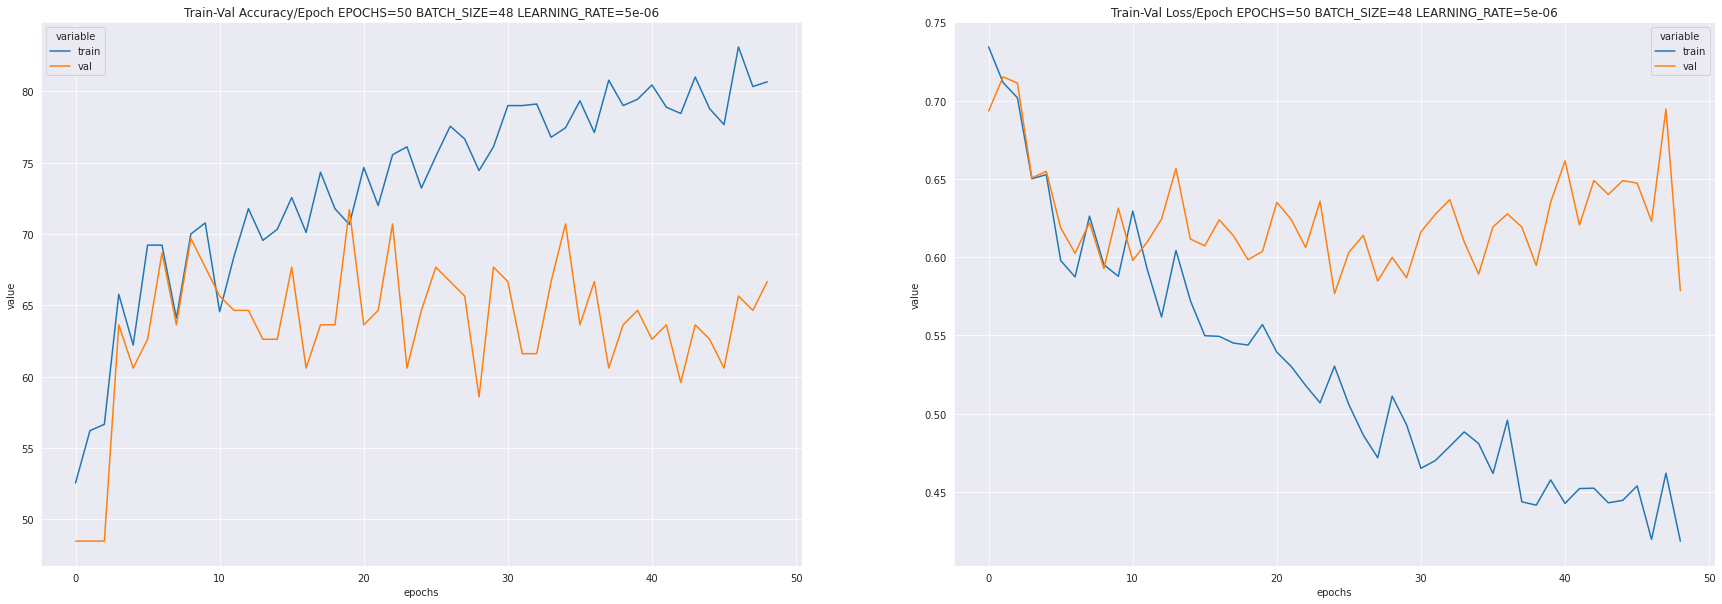

In [11]:
#Visualize Loss and Accuracy
#To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and 
#loss_stats dictionaries.

#print(len(accuracy_stats['train']))
#print(len(accuracy_stats['val']))
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# print((train_val_acc_df))

#print(len(loss_stats['train']))
#print(len(loss_stats['val']))
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
#print(train_val_loss_df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={EPOCHS} BATCH_SIZE={BATCH_SIZE} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Train-Val Loss/Epoch EPOCHS={EPOCHS} BATCH_SIZE={BATCH_SIZE} LEARNING_RATE={LEARNING_RATE}')




In [12]:

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)        
        
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

#We’ll flatten out the list so that we can use it as an input to confusion_matrix and classification_report.        
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]        


print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 154.95it/s]

y_pred_list[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1

In [13]:
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.67      0.47      0.55       250
           1       0.59      0.77      0.67       250

    accuracy                           0.62       500
   macro avg       0.63      0.62      0.61       500
weighted avg       0.63      0.62      0.61       500

[[117 133]
 [ 58 192]]


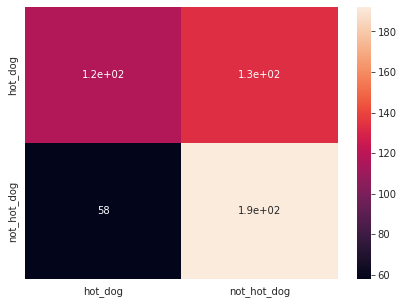

In [14]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()